# **Redes Neuronales Profundas (DNN)**

### Usaremos PyTorch para crear una red neuronal simple que predice el resultado de un partido deportivo basándose en ciertas características relevantes. 

Comenzamos importando todas las dependecias necesarias para el correcto funcionamiento del documento.

In [ ]:
# Importamos librerías

# Visualización de datos
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

# Manipulación y procesamiento de datos
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.model_selection import train_test_split

# Librerías de PyTorch
import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F

# Métricas de evaluación y análisis
from sklearn.metrics import confusion_matrix

Importamos los datos que usaremos posteriormente en nuestra red neuronal.

In [146]:
partidos = pd.read_csv('../../data/partidos_limpio.csv')
partidos.head()

,Season,Round,Day,Date,Results,Home,Country (Home),Points (Home),Score (Home),Score (Away),...,MP_away,Starts_away,Gls_away,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away
0,2023-2024,Round of 16,Tue,2024-02-13,A,RB Leipzig,Germany,88.736698,0,1,...,10.0,110.0,20.0,17.0,37.0,20.0,0.0,1.0,18.0,0.0
1,2023-2024,Round of 16,Tue,2024-02-13,A,FC Copenhagen,Denmark,80.431647,1,3,...,10.0,110.0,28.0,20.0,48.0,25.0,3.0,3.0,10.0,0.0
2,2023-2024,Round of 16,Wed,2024-02-14,H,Paris S-G,France,114.334580,2,0,...,8.0,88.0,8.0,5.0,13.0,8.0,0.0,1.0,18.0,0.0
3,2023-2024,Round of 16,Wed,2024-02-14,H,Lazio,Italy,99.943311,1,0,...,10.0,110.0,18.0,14.0,32.0,16.0,2.0,2.0,13.0,1.0
4,2023-2024,Round of 16,Tue,2024-02-20,D,PSV Eindhoven,The Netherlands,98.784903,1,1,...,10.0,110.0,15.0,12.0,27.0,14.0,1.0,1.0,16.0,0.0


### Preparación de los datos.

Las redes neuronales pueden manejar tanto variables numéricas como categóricas. Sin embargo, las variables numéricas pueden ser más fáciles de manejar y pueden proporcionar al modelo una señal más clara y directa para aprender. Las variables categóricas codificadas pueden introducir más complejidad en el modelo y pueden requerir técnicas adicionales, como la codificación one-hot, para ser correctamente interpretadas.

Por lo tanto, pasaremos todas nuestras variables categóricas a numéricas.

In [147]:
# Columnas a modificar
cols = ['Season', 'Round', 'Day', 'Date', 'Results', 'Home', 'Away', 'Country (Home)', 'Country (Away)', 'Venue', 'Referee', 'Year', 'Month', 'Number Day']

# Inicializamos el label encoder
label_encoder = LabelEncoder()

# Creamos un diccionario para guardar los mapeos de valores escalados
mapping = {}

# Transformamos la columna 'Date' a datetime
partidos['Date'] = pd.to_datetime(partidos['Date'])

# Iteramos sobre las columnas y las transformamos
for col in cols:
    # Si la columna es de tipo datetime, la transformamos a año, mes y día
    if col == 'Date':
        partidos['Year'] = partidos['Date'].dt.year
        partidos['Month'] = partidos['Date'].dt.month
        partidos['Number Day'] = partidos['Date'].dt.day
        continue
    
    # Guardamos los valores únicos originales antes de la transformación
    unique_values = partidos[col].unique()
    
    # Transformamos los valores usando LabelEncoder
    label_encoder.fit(unique_values)
    partidos[col] = label_encoder.transform(partidos[col])
    
    if col != 'Results':
        # Escalamos los valores transformados
        partidos[col] = scale(partidos[col])
        
    # Creamos un mapeo de los valores escalados con las clases del LabelEncoder como claves
    mapping[col] = dict(zip(unique_values, partidos[col]))

# Eliminamos la columna 'Date'
partidos.drop('Date', axis=1, inplace=True)

# Verificamos los cambios
partidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Season          598 non-null    float64
 1   Round           598 non-null    float64
 2   Day             598 non-null    float64
 3   Results         598 non-null    int32  
 4   Home            598 non-null    float64
 5   Country (Home)  598 non-null    float64
 6   Points (Home)   598 non-null    float64
 7   Score (Home)    598 non-null    int64  
 8   Score (Away)    598 non-null    int64  
 9   Points (Away)   598 non-null    float64
 10  Country (Away)  598 non-null    float64
 11  Away            598 non-null    float64
 12  Venue           598 non-null    float64
 13  Referee         598 non-null    float64
 14  # Pl_home       540 non-null    float64
 15  Age_home        540 non-null    float64
 16  MP_home         540 non-null    float64
 17  Starts_home     540 non-null    flo

También eliminamos aquellas filas que contengan datos nulos.

In [148]:
partidos = partidos.dropna()

### Modelo de Red Neuronal Profunda.

Ahora empezamos con nuestro modelo, seleccionando qué variable queremos predecir y cuáles introduciremos a nuestro modelo para que prediga la variable objetivo.

In [149]:
X = partidos.drop(labels=['Results', 'Score (Home)', 'Score (Away)', 'Referee'], axis=1)
y = partidos['Results']

# Estandarizamos los datos que nos quedan

# Columnas a estandarizar
cols = [['Points (Home)', 'Points (Away)', '# Pl_home','Age_home','MP_home','Starts_home','Gls_home','Ast_home','G+A_home','G-PK_home','PK_home','PKatt_home','CrdY_home','CrdR_home','# Pl_away','Age_away','MP_away','Starts_away','Gls_away','Ast_away','G+A_away','G-PK_away','PK_away','PKatt_away','CrdY_away','CrdR_away']]

# Se recorren las columnas especificadas y se escala cada una
for col in cols:
    X[col] = scale(X[col])

Separamos en test y train para predecir nuestro modelo.

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)

Establecemos una semilla aleatoria en PyTorch (o en cualquier otra biblioteca de aprendizaje automático) para garantizar la reproducibilidad de los resultados.

In [151]:
torch.manual_seed(0)

El próximo paso es crear conjuntos de datos y cargadores de datos (data loaders) para el entrenamiento y la prueba de tu modelo.

In [152]:
# Creamos un conjunto de datos y cargador para los datos de entrenamiento y etiquetas
train_x = torch.Tensor(X_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20,
    shuffle=False, num_workers=1)

# Creamos un conjunto de datos y cargador para los datos de prueba y etiquetas
test_x = torch.Tensor(X_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
    shuffle=False, num_workers=1)

# Mensaje indicando que los datos están listos para ser cargados
print('Ready to load data')

Ready to load data


Una vez creados los conjuntos de datos y data loaders, defininimos nuestra Read Neuronal Profunda (DNN) utilizando PyTorch.

In [153]:
# Número de nodos en la capa oculta
hl = 10

class ResultsNet(nn.Module):
    '''
    Clase que define la red neuronal para predecir los resultados de los partidos
    '''

    def __init__(self):
        '''
        Definir la estructura de la red neuronal
        '''
        super(ResultsNet, self).__init__()
        self.fc1 = nn.Linear(len(X.columns), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, len(list(mapping['Results'].keys())))

    def forward(self, x):
        '''
        Definir el flujo hacia adelante (forward pass) de la red neuronal.
        ReLU es la función de activación utilizada en las capas ocultas.
        '''
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# Creamos una instancia del modelo a partir de la red neuronal
model = ResultsNet()
print(model)

ResultsNet(
  (fc1): Linear(in_features=37, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


Con nuestra Red Neuronal Porfunda creada, es hora de entrenarla para poder hacer predicciones correctamente. Utilizaremos el algoritmo de optimización Adam para ajustar los pesos del modelo durante el entrenamiento.

In [154]:
def train(model, data_loader, optimizer):
    ''' 
    Función para entrenar el modelo
    '''

    # Primero establecemos el modelo en modo de entrenamiento
    model.train()
    train_loss = 0
    
    # Iteramos sobre los lotes de datos en el conjunto de datos de entrenamiento
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        # Propagación hacia adelante
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # Retropropagación
        loss.backward()
        optimizer.step()

    # Calculamos la pérdida promedio para el conjunto de datos de entrenamiento
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):
    ''' 
    Función para evaluar el modelo
    '''

    # Cambiamos el modelo a modo de evaluación (evitamos retropropagación   )
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Obtener la salida del modelo
            out = model(data)

            # Calcular la pérdida
            test_loss += loss_criteria(out, target).item()

            # Calcular la precisión
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # Calcular la pérdida promedio y la precisión para el conjunto de datos de prueba
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # Devolver la pérdida promedio
    return avg_loss

# Criterio de pérdida utilizado para calcular la pérdida entre las predicciones y las etiquetas reales
loss_criteria = nn.CrossEntropyLoss()

# Optimizador Adam utilizado para ajustar los pesos del modelo durante el entrenamiento
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Arrays para almacenar las métricas de entrenamiento
epoch_nums = []
training_loss = []
validation_loss = []

# Entrenar durante 50 épocas
epochs = 50
for epoch in range(1, epochs + 1):

    # Mostramos el número de época
    print('Epoch: {}'.format(epoch))
    
    # Entrenar el modelo con los datos de entrenamiento
    train_loss = train(model, train_loader, optimizer)
    
    # Evaluar el rendimiento del modelo con los datos de prueba
    test_loss = test(model, test_loader)
    
    # Registrar las métricas para esta época
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1


Training set: Average loss: 1.073321
Validation set: Average loss: 1.082607, Accuracy: 69/162 (43%)

Epoch: 2
Training set: Average loss: 1.057059
Validation set: Average loss: 1.075549, Accuracy: 72/162 (44%)

Epoch: 3
Training set: Average loss: 1.038059
Validation set: Average loss: 1.062403, Accuracy: 80/162 (49%)

Epoch: 4
Training set: Average loss: 1.013292
Validation set: Average loss: 1.041803, Accuracy: 90/162 (56%)

Epoch: 5
Training set: Average loss: 0.981931
Validation set: Average loss: 1.018371, Accuracy: 91/162 (56%)

Epoch: 6
Training set: Average loss: 0.944595
Validation set: Average loss: 0.995737, Accuracy: 94/162 (58%)

Epoch: 7
Training set: Average loss: 0.907006
Validation set: Average loss: 0.979315, Accuracy: 94/162 (58%)

Epoch: 8
Training set: Average loss: 0.875790
Validation set: Average loss: 0.971394, Accuracy: 95/162 (59%)

Epoch: 9
Training set: Average loss: 0.854001
Validation set: Average loss: 0.970284, Accuracy: 95/162 (59%)

Epoch: 10
Training 

La siguiente gráfica nos permite visualizar cómo la pérdida de entrenamiento y la pérdida de validación cambian a lo largo de las épocas durante el entrenamiento del modelo de red neuronal.

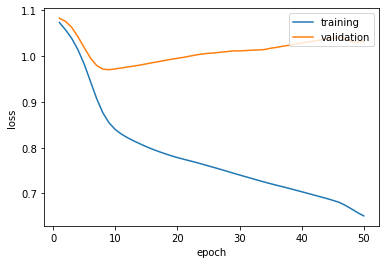

In [155]:
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Para mejorar la comprensión de la precisión y el comportamiento del modelo en diferentes clases de salida, haremos una matriz de confusión que expresa cómo el modelo de clasificación ha clasificado correctamente y erróneamente las instancias de cada clase en los datos de prueba.

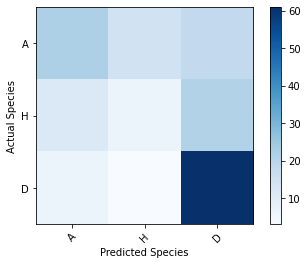

In [156]:
# Establecemos el modelo en modo de evaluación
model.eval()

# Obtenemos predicciones para los datos de prueba
x = torch.Tensor(X_test).float()
_, predicted = torch.max(model(x).data, 1)

# Visualizamos la matriz de confusión
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(list(mapping['Results'].keys())))
plt.xticks(tick_marks, list(mapping['Results'].keys()), rotation=45)
plt.yticks(tick_marks, list(mapping['Results'].keys()))
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()

Podemos observar que este modelo tiende a predecir empates.

### Predicciones

Una vez entrenado y evaluado nuestro modelo, podemos empezar a predecir los futuros partidos de la UEFA Champions League.

#### Semifinales

Creamos un DataFrame que incluya los cuatro partidos que se juegan en las semifinales de esta temporada 2023-2024.

In [157]:
semis = [['2023-2024', 'Semi-finals', 'Tue', 'Bayern Munich', 'Germany', 107.882298136646, 114.5545351473923, 'Spain', 'Real Madrid', 'Allianz Arena', 23, 28.3, 10, 110, 18, 14, 32, 16, 2, 2, 13.0, 1.0, 22, 28.0, 10, 110, 20, 17, 37, 20, 0, 1, 18.0, 0.0, 2024, 4, 30],
        ['2023-2024', 'Semi-finals', 'Wed', 'Dortmund', 'Germany', 91.17303312629399, 114.33458049886625, 'France', 'Paris S-G', 'Signal Iduna Park', 23, 28.0, 10, 110, 15, 12, 27, 14, 1, 1, 16.0, 0.0, 21, 25.3, 10, 110, 19, 12, 31, 16, 3, 3, 27.0, 0.0, 2024, 5, 1],
        ['2023-2024', 'Semi-finals', 'Tue', 'Paris S-G', 'France', 114.33458049886625, 91.17303312629399, 'Germany', 'Dortmund', 'Parc des Princes', 21, 25.3, 10, 110, 19, 12, 31, 16, 3, 3, 27.0, 0.0, 23, 28.0, 10, 110, 15, 12, 27, 14, 1, 1, 16.0, 0.0, 2024, 5, 7],
        ['2023-2024', 'Semi-finals', 'Wed', 'Real Madrid', 'Spain', 114.5545351473923, 107.882298136646, 'Germany', 'Bayern Munich', 'Estadio Santiago Bernabéu', 22, 28.0, 10, 110, 20, 17, 37, 20, 0, 1, 18.0, 0.0, 23, 28.3, 10, 110, 18, 14, 32, 16, 2, 2, 13.0, 1.0, 2024, 5, 8]]

partidos_cols = partidos.drop(labels=['Results', 'Score (Home)', 'Score (Away)', 'Referee'], axis=1).columns
semis = pd.DataFrame(semis, columns=(partidos_cols))

semis.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,2023-2024,Semi-finals,Tue,Bayern Munich,Germany,107.882298,114.554535,Spain,Real Madrid,Allianz Arena,...,17,37,20,0,1,18.0,0.0,2024,4,30
1,2023-2024,Semi-finals,Wed,Dortmund,Germany,91.173033,114.334580,France,Paris S-G,Signal Iduna Park,...,12,31,16,3,3,27.0,0.0,2024,5,1
2,2023-2024,Semi-finals,Tue,Paris S-G,France,114.334580,91.173033,Germany,Dortmund,Parc des Princes,...,12,27,14,1,1,16.0,0.0,2024,5,7
3,2023-2024,Semi-finals,Wed,Real Madrid,Spain,114.554535,107.882298,Germany,Bayern Munich,Estadio Santiago Bernabéu,...,14,32,16,2,2,13.0,1.0,2024,5,8


Usamos el diccionario que creamos antes para mapear las columnas categóricas para convertirlas todas a numéricas con valores ya estandarizados.

In [158]:
data = semis.copy()

# Aplicamos mapping a las columnas
for col, col_mapping in mapping.items():
    if col in data.columns:
        data[col] = data[col].map(col_mapping)
    else:
        if col == 'Squad':
            data['Home'] = data['Home'].map(col_mapping)
            data['Away'] = data['Away'].map(col_mapping)
        elif col == 'Country':
            data['Country (Home)'] = data['Country (Home)'].map(col_mapping)
            data['Country (Away)'] = data['Country (Away)'].map(col_mapping)

data.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,1.687752,0.299762,-0.467463,-1.175076,-0.495540,107.882298,114.554535,1.257957,1.181904,-1.456509,...,17,37,20,0,1,18.0,0.0,1.687752,-1.179612,0.076669
1,1.687752,0.299762,-0.467463,-0.685127,-0.495540,91.173033,114.334580,-0.486073,0.909543,0.748021,...,12,31,16,3,3,27.0,0.0,1.687752,-1.179612,0.883375
2,1.687752,0.299762,-0.467463,0.893597,-0.786919,114.334580,91.173033,1.257957,-0.670156,0.573979,...,12,27,14,1,1,16.0,0.0,1.687752,-1.179612,-0.326685
3,1.687752,0.299762,-0.467463,1.165790,0.378598,114.554535,107.882298,1.257957,-1.160407,-0.615307,...,14,32,16,2,2,13.0,1.0,1.687752,-1.179612,-0.192234


Antes de predecir los resultados, estandarizamos los valores restantes.

In [159]:
# Columnas a estandarizar
cols = [['Points (Home)', 'Points (Away)', '# Pl_home','Age_home','MP_home','Starts_home','Gls_home','Ast_home','G+A_home','G-PK_home','PK_home','PKatt_home','CrdY_home','CrdR_home','# Pl_away','Age_away','MP_away','Starts_away','Gls_away','Ast_away','G+A_away','G-PK_away','PK_away','PKatt_away','CrdY_away','CrdR_away']]

# Se recorren las columnas especificadas y se escala cada una
for col in cols:
    data[col] = scale(data[col])

Hacemos una predicción del nuevo conjunto de datos y además obtenemos la probabilidad de cada posible predicción. De esta manera, podemos saber claramente quién pasa a la siguiente ronda en caso de dudas.

In [160]:
# Obtener una predicción para el nuevo conjunto de datos
x = torch.Tensor(data.values).float()
output = model(x)
probabilities = F.softmax(output, dim=1)  # Aplicar softmax a las salidas

# Obtener las clases predichas y las probabilidades asociadas a todas las clases
predicted_classes = torch.max(output.data, 1)[1]
all_probabilities = probabilities.data.numpy()  # Convertir a un arreglo numpy

# Obtener los posibles valores que puede tomar la variable objetivo del modelo
possible_classes = list(mapping['Results'].keys())

# Crear un DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=['Home', 'Away'] + possible_classes)

# Iterar sobre las predicciones y las probabilidades
for i in range(len(predicted_classes)):
    # Obtener las probabilidades para la predicción actual
    probabilities_dict = {possible_classes[j]: all_probabilities[i][j] * 100 for j in range(len(possible_classes))}
    
    # Agregar una fila al DataFrame con las probabilidades de la predicción actual
    result_row = {'Home': semis.iloc[i]['Home'], 'Away': semis.iloc[i]['Away']}
    result_row.update(probabilities_dict)
    results_df = results_df.append(result_row, ignore_index=True)

# Mostrar el DataFrame
results_df

C:\Users\Laura Rodríguez\AppData\Local\Temp\ipykernel_1256\2348556990.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
C:\Users\Laura Rodríguez\AppData\Local\Temp\ipykernel_1256\2348556990.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
C:\Users\Laura Rodríguez\AppData\Local\Temp\ipykernel_1256\2348556990.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
C:\Users\Laura Rodríguez\AppData\Local\Temp\ipykernel_1256\2348556990.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

,Home,Away,A,H,D
0,Bayern Munich,Real Madrid,17.951104,17.951104,64.097798
1,Dortmund,Paris S-G,55.638629,25.203982,19.157383
2,Paris S-G,Dortmund,10.578398,13.990135,75.431466
3,Real Madrid,Bayern Munich,13.880162,17.74535,68.374491


Vemos que la mayoría de los partidos resultan en empate a excepción de uno de ellos, donde lo gana el Paris S-G. Fijándonos en el resto de probabilidades podemos determinar que pasa a la final el Real Madrid ya que en el primer partido ambos equipos tienen la misma probabilidad de ganar, sin embargo en el segundo partido el Real Madrid tiene más probabilidad de ganar.

Por lo tanto, podemos concluir que la final de este modelo es: Real Madrid vs Paris S-G.

#### Final

Creamos un DataFrame con estos datos y volvemos a predecir el ganador con nuestro modelo para finalmente poder determinar el ganador del torneo.

In [161]:
final = [['2023-2024', 'Final', 'Sat', 'Real Madrid', 'Spain', 114.5545351473923, 114.33458049886625, 'France', 'Paris S-G', 'Wembley Stadium', 22, 28.0, 10, 110, 20, 17, 37, 20, 0, 1, 18.0, 0.0, 21, 25.3, 10, 110, 19, 12, 31, 16, 3, 3, 27.0, 0.0, 2024, 6, 1]]
final = pd.DataFrame(final, columns=(partidos_cols))

final.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,2023-2024,Final,Sat,Real Madrid,Spain,114.554535,114.33458,France,Paris S-G,Wembley Stadium,...,12,31,16,3,3,27.0,0.0,2024,6,1


Convertimos las columnas categóricas a numéricas usando mapeo.

In [162]:
data = final.copy()

# Aplicamos mapping a las columnas
for col, col_mapping in mapping.items():
    if col in data.columns:
        data[col] = data[col].map(col_mapping)
    else:
        if col == 'Squad':
            data['Home'] = data['Home'].map(col_mapping)
            data['Away'] = data['Away'].map(col_mapping)
        elif col == 'Country':
            data['Country (Home)'] = data['Country (Home)'].map(col_mapping)
            data['Country (Away)'] = data['Country (Away)'].map(col_mapping)

data.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,1.687752,0.299762,0.753248,1.16579,0.378598,114.554535,114.33458,-0.486073,0.909543,-1.456509,...,12,31,16,3,3,27.0,0.0,1.687752,-1.179612,0.883375


Por último, predecimos y mostramos el resultado.

In [163]:
# Obtener una predicción para el nuevo conjunto de datos
x = torch.Tensor(data.values).float()
_, predicted = torch.max(model(x).data, 1)

# Obtener los posibles valores que puede tomar la variable objetivo del modelo
possible_classes = list(mapping['Results'].keys())

pred = possible_classes[predicted.item()]

# Crear un DataFrame para almacenar los resultados
results_df = pd.DataFrame(columns=['Home', 'Away', 'Results'])

results_df['Home'] = final['Home']
results_df['Away'] = final['Away']
results_df['Results'] = pred

# Mostrar el DataFrame
results_df

,Home,Away,Results
0,Real Madrid,Paris S-G,A


Finalmente vemos que el ganador de la UEFA Champions League para nuestra Red Neuronal Profunda es Paris S-G.

Veamos como se verían los resultados del torneo.

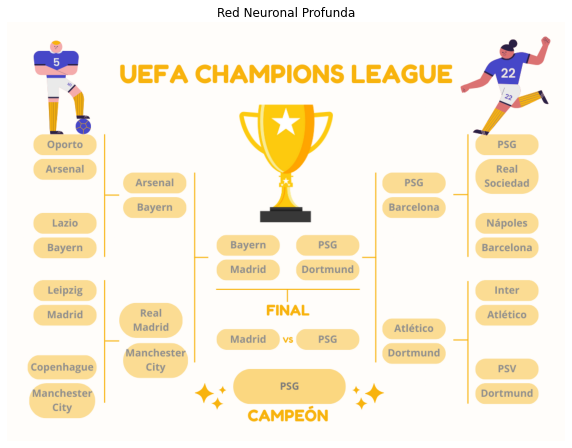

In [4]:
# Ruta de la imagen
ruta_imagen = '../../img/clasificaciones/DNN.png'

# Mostrar la imagen
plt.figure(figsize=(10,10))
img = mpimg.imread(ruta_imagen)
plt.imshow(img)
plt.title('Red Neuronal Profunda')
plt.axis('off')  # Para ocultar los ejes
plt.show()